In [127]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot

from keras.datasets import mnist



In [113]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [114]:
print('X_train: ' , train_X.shape)
print('Y_train: ', (train_y.shape))
print('X_test:  ', (test_X.shape))
print('Y_test:  ', test_y.shape)

X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:   (10000, 28, 28)
Y_test:   (10000,)


# DataLoader

In [115]:
class MNIST(Dataset):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
    
    

In [134]:
train_dl = DataLoader(MNIST(train_X, train_y), batch_size=len(train_X))
test_dl = DataLoader(MNIST(test_X, test_y), batch_size=10)

# Criando o Modelo


Irei pegar cada dado, transformar o tensor em um tensor de 1 dimensão e depois aplicar o Linear interpolado por Relu. Já Na saída vou pegar os dados do Linear e sair 10 resultados (0,1,2,3,4...8,9)

In [117]:
class MLP_Model(nn.Module):
    def __init__(self):
        super(MLP_Model,self).__init__()



        # nn.Sequential()
        self.Flat = nn.Flatten()
        self.L1 = nn.Linear(28*28,20)
        self.A1 = nn.ReLU()
        self.L2 = nn.Linear(20,10)
        
        
        
        
    def forward(self, x):
        
        x = self.Flat(x)
        
        x = self.L1(x)
        x = self.A1(x)
        x = self.L2(x)
        
        return x
        
        

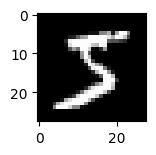

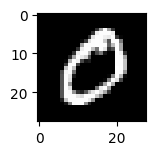

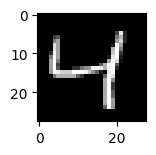

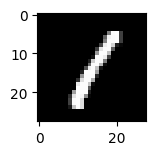

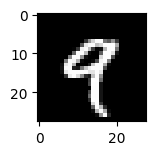

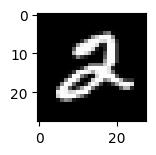

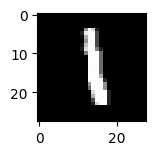

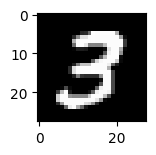

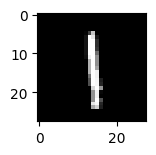

In [136]:
for xb, yb in train_dl:
    for i in range(9):  
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(xb[i], cmap=pyplot.get_cmap('gray'))
        pyplot.show()

# Train

In [140]:
def training( N_Epochs, model, loss_fn, opt  ):
    
    loss_list = []
    
    for epoch in range(N_Epochs+1):
        for xb, yb in train_dl:
            
            
            y_pred = model(xb.float())
            loss   = loss_fn(y_pred, yb.long())
        
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        
            print(epoch, "loss=", loss.item())
            loss_list.append(loss.item())
            
    
    plt.figure(figsize = (14,6))
    plt.title("cost decay")
    plt.plot(loss_list)
    plt.xlabel("epoch")
    plt.ylabel("cost")
    

0 loss= 27.40256690979004
1 loss= 24.492223739624023
2 loss= 9.633039474487305
3 loss= 4.445470333099365
4 loss= 2.7735657691955566
5 loss= 2.2348358631134033
6 loss= 2.161374807357788
7 loss= 2.165544033050537
8 loss= 2.1639974117279053
9 loss= 2.152559280395508
10 loss= 2.1360185146331787
11 loss= 2.120835781097412
12 loss= 2.1097841262817383
13 loss= 2.1023480892181396
14 loss= 2.0959079265594482
15 loss= 2.0887463092803955
16 loss= 2.081209182739258
17 loss= 2.073911666870117
18 loss= 2.0669941902160645
19 loss= 2.059908390045166
20 loss= 2.051605224609375
21 loss= 2.0410878658294678
22 loss= 2.0264830589294434
23 loss= 2.009652614593506
24 loss= 1.993483543395996
25 loss= 1.9862231016159058
26 loss= 1.986234188079834
27 loss= 1.9779043197631836
28 loss= 1.9644030332565308
29 loss= 1.9521160125732422
30 loss= 1.9442894458770752
31 loss= 1.9391553401947021
32 loss= 1.9356456995010376
33 loss= 1.9318876266479492
34 loss= 1.9278819561004639
35 loss= 1.924733281135559
36 loss= 1.922672

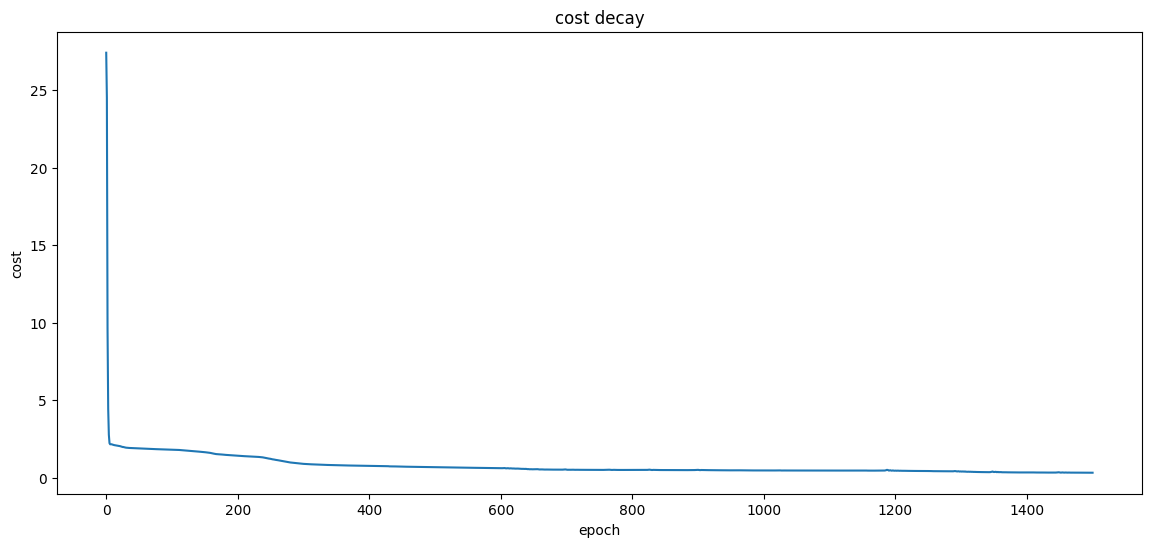

In [144]:
model = MLP_Model()

epochs = 1500

opt        = torch.optim.Adam( model.parameters(), lr=0.003 )

loss_fn    = nn.CrossEntropyLoss( )   

training(  epochs, model , loss_fn, opt  )


# Evaluation

In [145]:
with torch.no_grad():
    model.eval()
    
    for xb, yb in test_dl:
        
        
        y_pred = model(xb.float())



    
    yf = torch.argmax(y_pred, dim=1)
    
    print(classification_report(yb, yf))        
        
            
            

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

